# Creating NBA Shot Charts with Python

## Dependencies

In [1]:
from nba_api.stats.endpoints import shotchartdetail, playercareerstats
from nba_api.stats.static import players, teams
from modules.datasets import Datasets
from modules.charts.charts import ShotCharts
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
# get player id
name = "Isaiah Thomas"
id = Datasets.get_json_from_name(name)['id']
career = Datasets.get_player_career(id)
teams = ['BOS', 'CLE']
team_ids = list(set(career[career.TEAM_ABBREVIATION.isin(teams)].TEAM_ID.values))

seasons = ['2016-17', '2017-18']
shot_data = Datasets.get_shot_data(id, team_ids, seasons)
shot_data.tail()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
189,Shot Chart Detail,0021700807,109,202738,Isaiah Thomas,1610612739,Cleveland Cavaliers,1,1,54,...,Left Side(L),8-16 ft.,9,-84,38,1,0,20180207,CLE,MIN
190,Shot Chart Detail,0021700807,253,202738,Isaiah Thomas,1610612739,Cleveland Cavaliers,2,3,32,...,Right Side(R),16-24 ft.,17,171,11,1,0,20180207,CLE,MIN
191,Shot Chart Detail,0021700807,324,202738,Isaiah Thomas,1610612739,Cleveland Cavaliers,3,9,12,...,Left Side Center(LC),24+ ft.,24,-149,199,1,1,20180207,CLE,MIN
192,Shot Chart Detail,0021700807,357,202738,Isaiah Thomas,1610612739,Cleveland Cavaliers,3,5,37,...,Left Side Center(LC),24+ ft.,25,-128,220,1,1,20180207,CLE,MIN
193,Shot Chart Detail,0021700807,521,202738,Isaiah Thomas,1610612739,Cleveland Cavaliers,4,3,57,...,Left Side Center(LC),24+ ft.,24,-128,210,1,1,20180207,CLE,MIN


## Shot Charts

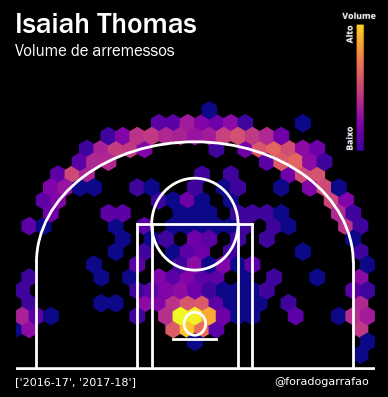

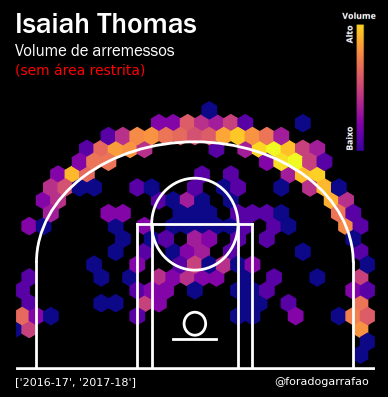

In [3]:
chart1 = ShotCharts.volume_chart(shot_data, name, seasons)
chart2 = ShotCharts.volume_chart(shot_data, name, seasons, RA=False)
plt.show()

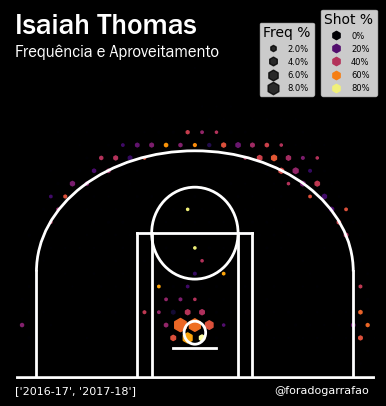

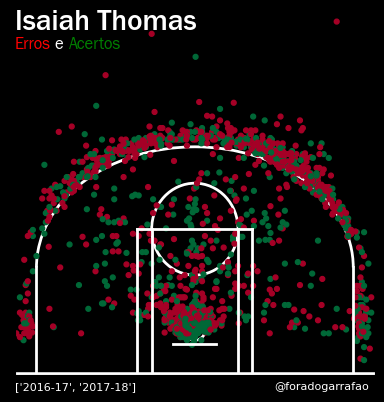

In [4]:
chart3 = ShotCharts.frequency_chart(shot_data, name, seasons)
chart4 = ShotCharts.makes_misses_chart(shot_data, name, seasons)
plt.show()